# Granular Marking Test Notebook

## Aim
1. To setup some example SDO's with Granular Markings and test the claim that idempotency means we cannot resolve the attributes correctly
2. To setup some EXIF key/values to prove that idempotency means attributes cannot own attributes

## Method Stage 1
Setup 3 objects, 2 Indicator SDO's and a Campaign SDO. This enables us to test:
- Description: All object have a description field, and we will make all of the descriptions the same to see if the relationship resolves properly
- List Indexing: We will setup two Indicator Type Lists, each with the same words, just in different orders. They will then be assigned to indicator objects and marked to see if they values and order can be properly retrieved

## Imports
First setup Imports



In [16]:
import sys
!{sys.executable} -m pip install stixorm
from stixorm.module.typedb import TypeDBSink, TypeDBSource
from stixorm.module.authorise import import_type_factory
from stixorm.module.definitions.stix21 import (
    Indicator, Campaign, Bundle, File, RasterImageExt
)
from stixorm.module.authorise import import_type_factory
from stixorm.module.typedb_lib.instructions import ResultStatus, Result
import_type = import_type_factory.get_all_imports()
import logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

## Setup Granular Marking Variables

Setup marking object id's for Red, White, Green and Amber marking objects. Setup selector variables for the description field (used on multiple SDO's), and setup two selector id's for the "indicator_types" list (only available on the Indicator SDO)


In [11]:
white_id = "marking-definition--613f2e26-407d-48c7-9eca-b8e91df99dc9"
green_id = "marking-definition--34098fce-860f-48ae-8e50-ebd3cc5e41da"
amber_id = "marking-definition--f88d31f6-486f-44da-b317-01333bde0b82"
red_id = "marking-definition--5e57c739-391a-4eb3-b6be-7d15ca92d5ed"

desc_selector = [ "description" ]
ind_type0_selector = [ "indicator_types.[0]" ]
ind_type1_selector = [ "indicator_types.[1]" ]

# Setup Object Variables

Setup variables used to define the objects, the indicator_types and the actual Granular Markings.


In [12]:
ind_types1 = [ "malicious-activity", "attribution"]
ind_types2 = [ "attribution", "malicious-activity"]
description = "A Common Description"

ind_gran_mark1 = [{ "marking_ref": white_id, "selectors": desc_selector}, { "marking_ref": green_id, "selectors": ind_type0_selector}, { "marking_ref": amber_id, "selectors": ind_type1_selector}]
ind_gran_mark2 = [{ "marking_ref": green_id, "selectors": desc_selector}, { "marking_ref": white_id, "selectors": ind_type0_selector}, { "marking_ref": red_id, "selectors": ind_type1_selector}]
camp_gran_mark = [ { "marking_ref": green_id, "selectors": desc_selector}]

## Setup Actual Objects

Setup the two Indicator objects and the Campaign object, with their Granular Markings.


In [13]:
pat1 = "[email-addr:value = 'evil@northkorea.nk' AND email:subject = 'Come Join Us']"
ind1 = Indicator(name="Suspicious Email", description=description, pattern_type="stix", pattern=pat1, indicator_types=ind_types1, granular_markings=ind_gran_mark1)

pat2 = "[email-addr:value = 'nefariou@northkorea.nk' AND email:subject = 'We are coming for you']"
ind2 = Indicator(name="Nefarious Email", description=description, pattern_type="stix", pattern=pat2, indicator_types=ind_types2, granular_markings=ind_gran_mark2)

camp = Campaign(name="Coming For You",  description=description, granular_markings=camp_gran_mark)

bundle = Bundle(ind1, ind2, camp)

print(bundle.serialize(pretty=True))

{
    "type": "bundle",
    "id": "bundle--2438e0cb-886a-4282-80c4-a0f609bc481e",
    "objects": [
        {
            "type": "indicator",
            "spec_version": "2.1",
            "id": "indicator--9b331ce5-7ba5-4643-9910-b3447aecce34",
            "created": "2023-11-30T05:33:12.643716Z",
            "modified": "2023-11-30T05:33:12.643716Z",
            "name": "Suspicious Email",
            "description": "A Common Description",
            "indicator_types": [
                "malicious-activity",
                "attribution"
            ],
            "pattern": "[email-addr:value = 'evil@northkorea.nk' AND email:subject = 'Come Join Us']",
            "pattern_type": "stix",
            "pattern_version": "2.1",
            "valid_from": "2023-11-30T05:33:12.643716Z",
            "granular_markings": [
                {
                    "marking_ref": "marking-definition--613f2e26-407d-48c7-9eca-b8e91df99dc9",
                    "selectors": [
                     

## Import into TypeDB

Setup the connection and then add to TypeDB. Note it must be a standard TypeDB server, not a cluster.


In [14]:
connection = {
    "uri": "localhost",
    "port": "1729",
    "database": "stix",
    "user": None,
    "password": None
}

# Initialise TypeDB
reinitilise = True
typedb = TypeDBSink(connection=connection, clear=reinitilise, import_type=import_type)

# add the list to TypeDB
results_raw = typedb.add(bundle)
result_list = [res.model_dump_json() for res in results_raw]

## Now Get the Objects and check they are the same

In [15]:
# get the id's for the loaded objects
ind1_id = ind1.id
ind2_id = ind2.id
camp_id = camp.id

#now get the objects from typedb
typedb_source = TypeDBSource(connection, import_type)
ind1_object = typedb_source.get(ind1_id)
ind2_object = typedb_source.get(ind2_id)
camp_object = typedb_source.get(camp_id)

print(ind1_object.serialize(pretty=True))
print(ind2_object.serialize(pretty=True))
print(camp_object.serialize(pretty=True))

{
    "type": "indicator",
    "spec_version": "2.1",
    "id": "indicator--9b331ce5-7ba5-4643-9910-b3447aecce34",
    "created": "2023-11-29T18:33:12.643Z",
    "modified": "2023-11-29T18:33:12.643Z",
    "name": "Suspicious Email",
    "description": "A Common Description",
    "indicator_types": [
        "attribution",
        "malicious-activity"
    ],
    "pattern": "[email-addr:value = 'evil@northkorea.nk' AND email:subject = 'Come Join Us']",
    "pattern_type": "stix",
    "pattern_version": "2.1",
    "valid_from": "2023-11-29T18:33:12.643Z",
    "granular_markings": [
        {
            "marking_ref": "marking-definition--613f2e26-407d-48c7-9eca-b8e91df99dc9",
            "selectors": [
                "description"
            ]
        },
        {
            "marking_ref": "marking-definition--f88d31f6-486f-44da-b317-01333bde0b82",
            "selectors": [
                "indicator_types.[0]"
            ]
        },
        {
            "marking_ref": "marking-d

get; get;

## Interpreting Results - Falsified Idempotency for Teneray Relation
The above returned objects look exactly the same as the input objects, check print outs. Note that the stix-id's will change each time this is run

You can go to TypeDB studio and type in

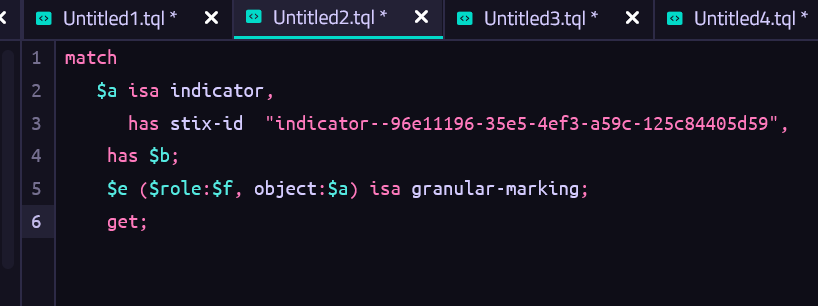

Changing the stix-id to suit the generated id's in the print field above. If you want to inspect all  of the granular marked objects, then use

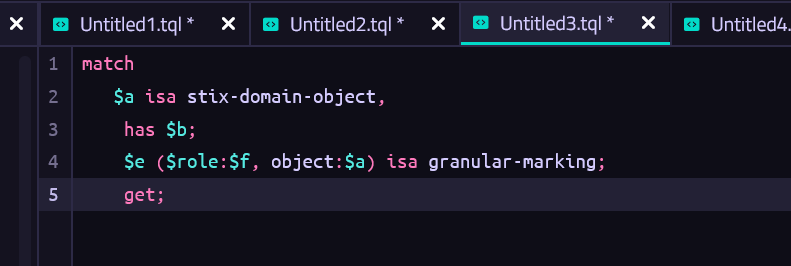

## Method Stage 2
This time we try to demonstrate idempotency by using relations where an **attribute owns another attribute**, and the name of the key is the same, but the key values are different between two objects. In this case we expect idempotency and should be able to demonstrate it.

Our example object is the File SCO, with the [Raster Image extension](https://docs.oasis-open.org/cti/stix/v2.1/os/stix-v2.1-os.html#_u5z7i2ox8w4x), (see link)

Our approach will be to setup three file objects, with the same key names "Make" and "Model", but different values in each, and then see what happens

## Setup EXIF_Tags Dictionaries

In [19]:
exif_dict1 = {"Make": "Alfa Romeo", "Model": "105GTV"}
exif_dict2 = {"Make": "Porchse", "Model": "911"}
exif_dict3 = {"Make": "Morris", "Model": "1100"}

raster_ext1 = RasterImageExt(exif_tags=exif_dict1)
raster_ext2 = RasterImageExt(exif_tags=exif_dict2)
raster_ext3 = RasterImageExt(exif_tags=exif_dict3)

file1 = File(name="Classic Car", extensions={'raster-image-ext':raster_ext1})
file2 = File(name="Dream Car", extensions={'raster-image-ext':raster_ext2})
file3 = File(name="Actual Car", extensions={'raster-image-ext':raster_ext3})

bundle2 = Bundle(file1, file2, file3)

print(bundle2.serialize(pretty=True))


{
    "type": "bundle",
    "id": "bundle--b0174168-e625-42df-8af1-688f08782065",
    "objects": [
        {
            "type": "file",
            "spec_version": "2.1",
            "id": "file--e6e2690e-b193-592d-887a-6fecd3c4ec56",
            "name": "Classic Car",
            "extensions": {
                "raster-image-ext": {
                    "exif_tags": {
                        "Make": "Alfa Romeo",
                        "Model": "105GTV"
                    }
                }
            }
        },
        {
            "type": "file",
            "spec_version": "2.1",
            "id": "file--9f619e86-2f51-5f95-8582-a191133dad14",
            "name": "Dream Car",
            "extensions": {
                "raster-image-ext": {
                    "exif_tags": {
                        "Make": "Porchse",
                        "Model": "911"
                    }
                }
            }
        },
        {
            "type": "file",
            "spec_v

## Add Bundle to TypeDB

This time add, but keep the other objects (i.e. reinitialze = False)

In [20]:

# add the list to TypeDB
results_raw2 = typedb.add(bundle2)
result_list2 = [res.model_dump_json() for res in results_raw2]

## Get the objects from TypeDB

and then print

In [21]:
file1_id = file1.id
file2_id = file2.id
file3_id = file3.id


#now get the objects from typedb
typedb_source = TypeDBSource(connection, import_type)
ret_file1 = typedb_source.get(file1_id)
ret_file2 = typedb_source.get(file2_id)
ret_file3 = typedb_source.get(file3_id)

print(ret_file1.serialize(pretty=True))
print(ret_file2.serialize(pretty=True))
print(ret_file3.serialize(pretty=True))

{
    "type": "file",
    "spec_version": "2.1",
    "id": "file--e6e2690e-b193-592d-887a-6fecd3c4ec56",
    "name": "Classic Car",
    "extensions": {
        "raster-image-ext": {
            "exif_tags": {
                "Make": [
                    "Morris",
                    "Porchse",
                    "Alfa Romeo"
                ],
                "Model": [
                    "911",
                    "1100",
                    "105GTV"
                ]
            }
        }
    }
}
{
    "type": "file",
    "spec_version": "2.1",
    "id": "file--9f619e86-2f51-5f95-8582-a191133dad14",
    "name": "Dream Car",
    "extensions": {
        "raster-image-ext": {
            "exif_tags": {
                "Make": [
                    "Morris",
                    "Porchse",
                    "Alfa Romeo"
                ],
                "Model": [
                    "911",
                    "1100",
                    "105GTV"
                ]
            }
  

## Interpreting Results - Proved Idempotency for Attribute owning another Attribute 
Note that the has relation does not have an independnet life, and is referenced through the first attribute, hence this test is conclusive

The proof is that 
# Attributes are Idempotent Only When in a Has Relation, as the Relation Has No External Independent Existience